<a href="https://colab.research.google.com/github/ChoYeongjo/book-pytorch-ai-app-practice/blob/main/250908_book_ai_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#250908 파이토치 딥러닝 모델 AI앱 개발 입문 - 아즈마 유키나가, 김은철 / AK IT
#250912 책 코드 별로 파이토치 튜토리얼 -> 파이토치 딥러닝 모델 AI앱 개발 입문 다시 복귀

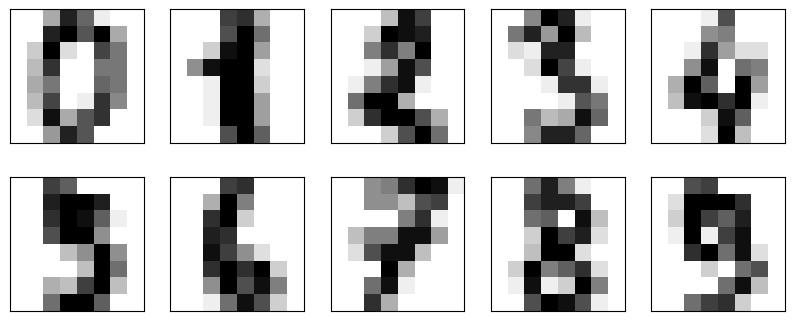

데이터 형태:  (1797, 64)
라벨:  [0 1 2 3 4 5 6 7 8 9]


In [2]:
#3.6 간단한 심층학습의 구현 p.103 -> 책에서는 손글씨로 그냥 예제 실습 시작
import matplotlib.pyplot as plt
from sklearn import datasets

# 데이터 셋
digits_data=datasets.load_digits()

#셋 간단 출력 및 확인
n_img=10
plt.figure(figsize=(10,4))
for i in range(n_img):
  ax=plt.subplot(2,5,i+1)
  ax.imshow(digits_data.data[i].reshape(8,8), cmap='gray_r')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

print("데이터 형태: ",digits_data.data.shape)
print("라벨: ",digits_data.target[:n_img])

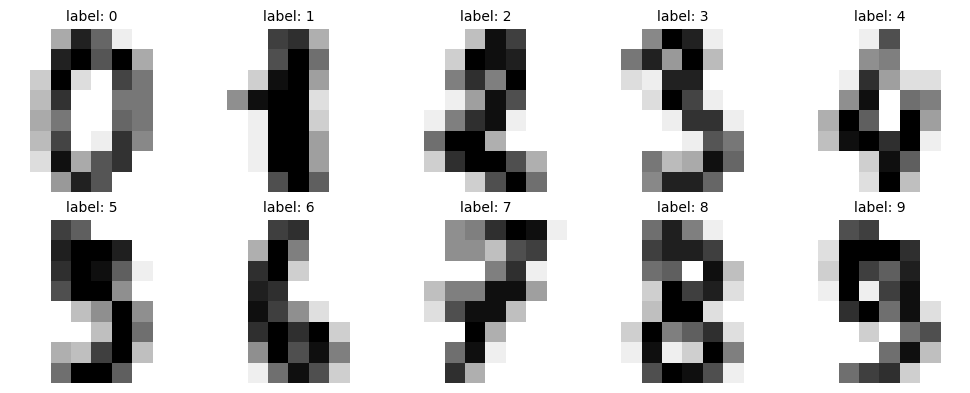

데이터 형태:  (1797, 64)
라벨:  [0 1 2 3 4 5 6 7 8 9]


In [3]:
# 책 코드를 약간 수정
import matplotlib.pyplot as plt
from sklearn import datasets

digits_data=datasets.load_digits()
n_img=10

plt.figure(figsize=(10,4))
for i in range(n_img):
  ax=plt.subplot(2,5,i+1)
  ax.imshow(digits_data.images[i], cmap='gray_r')
  ax.set_title(f"label: {digits_data.target[i]}", fontsize=10)
  ax.axis('off')

plt.tight_layout()
plt.show()

print("데이터 형태: ", digits_data.data.shape)
print("라벨: ", digits_data.target[:n_img])

In [4]:
# 책 -> 내 스타일로 수정
import torch
from sklearn.model_selection import train_test_split

digit_images=digits_data.data
label=digits_data.target

X_train, X_test, y_train, y_target = train_test_split(digit_images, label)

In [5]:
X_train.shape, X_train.dtype

((1347, 64), dtype('float64'))

In [6]:
X_train=torch.tensor(X_train, dtype=torch.float32)
X_test=torch.tensor(X_test, dtype=torch.float32)
y_train=torch.tensor(y_train, dtype=torch.long)
y_test=torch.tensor(y_target, dtype=torch.long)

In [7]:
from torch import nn

device=(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device.")

class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_relu_stack=nn.Sequential(
        nn.Linear(64,32),
        nn.ReLU(),
        nn.Linear(32,16),
        nn.ReLU(),
        nn.Linear(16,10)
    )
  def forward(self, x):
    logits=self.linear_relu_stack(x)
    return logits

model=NeuralNetwork().to(device)
print(model)

Using cuda device.
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [8]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(), lr=1e-2)
#여기 책은 시각화 툴 안 쓰고 그냥 에러로그 저장해서 그래프 그림
#손실로그
record_loss_train=[]
record_loss_test=[]

In [9]:
#책에서 그냥 for문안에서 돌림

from torch.utils.data import TensorDataset, DataLoader
batch_size=64
dataloader_train=DataLoader(TensorDataset(X_train, y_train),batch_size=batch_size)
dataloader_test=DataLoader(TensorDataset(X_test,y_test),batch_size=batch_size)

def train(model, dataloader, loss_fn, optimizer):
  size=len(dataloader.dataset)
  for batch, (X,y) in enumerate(dataloader):
    X,y=X.to(device), y.to(device)

    pred=model(X)
    loss=loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch%10==0:
      print(f"[loss:{loss.item():.4f}   current:{(batch+1)*len(X):>6}/{size}]")

  record_loss_train.append(loss.item())

def test(model, dataloader, loss_fn):
  model.eval()
  size=len(dataloader.dataset)
  num_batches=len(dataloader)
  loss_test, correct = 0,0

  with torch.no_grad():
    for batch,(X,y) in enumerate(dataloader):
      X,y=X.to(device), y.to(device)
      pred=model(X)
      loss_test+=loss_fn(pred, y)
      correct+= (y==pred.argmax(1)).to(float).sum().item()

    record_loss_test.append(loss_test.item()/num_batches)
  print(f"TEST->accuracy:{correct/size*100:.3f}% Avg loss:{loss_test.item()/num_batches:.4f}\n")

In [10]:
# 100 epoch

epochs=100
for i in range(epochs):
  print(f"epoch {i}\n{'-'*20}")
  train(model,dataloader_train,loss_fn,optimizer)
  test(model,dataloader_train,loss_fn)
print("Done!")

epoch 0
--------------------
[loss:2.6766   current:    64/1347]
[loss:2.2104   current:   704/1347]
[loss:2.1187   current:  1344/1347]
TEST->accuracy:18.189% Avg loss:2.0696

epoch 1
--------------------
[loss:2.0284   current:    64/1347]
[loss:1.9309   current:   704/1347]
[loss:1.8862   current:  1344/1347]
TEST->accuracy:27.468% Avg loss:1.8509

epoch 2
--------------------
[loss:1.8080   current:    64/1347]
[loss:1.7015   current:   704/1347]
[loss:1.6122   current:  1344/1347]
TEST->accuracy:39.347% Avg loss:1.5975

epoch 3
--------------------
[loss:1.5616   current:    64/1347]
[loss:1.4359   current:   704/1347]
[loss:1.2641   current:  1344/1347]
TEST->accuracy:55.234% Avg loss:1.3129

epoch 4
--------------------
[loss:1.3008   current:    64/1347]
[loss:1.1389   current:   704/1347]
[loss:0.9292   current:  1344/1347]
TEST->accuracy:59.169% Avg loss:1.1354

epoch 5
--------------------
[loss:1.1367   current:    64/1347]
[loss:0.8985   current:   704/1347]
[loss:0.7112  

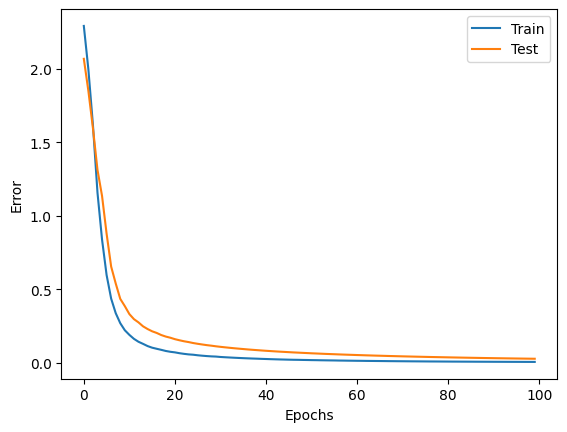

In [11]:
#책 오차추이
import matplotlib.pyplot as plt
plt.plot(range(len(record_loss_train)), record_loss_train, label="Train" )
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test" )
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

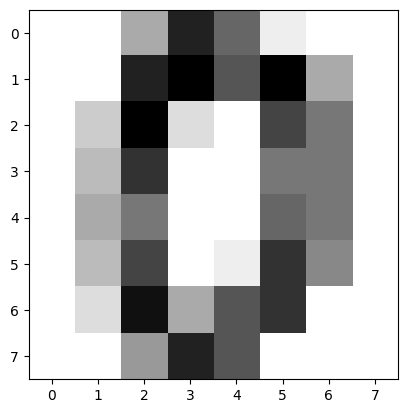

In [12]:
#책 3.6.7  훈련한 모델을 사용한 측정 p.111
plt.imshow(digit_images[0].reshape(8,8),cmap='gray_r')
plt.show()

In [13]:
y_pred=model(torch.tensor(digit_images[0],dtype=torch.float32).to(device))
print(f"정답: {label[0]} 예측결과 : {y_pred.argmax().item()}")

정답: 0 예측결과 : 0


In [14]:
y_pred=model(torch.tensor(digit_images[128],dtype=torch.float32).to(device))
print(f"정답: {label[128]} 예측결과 : {y_pred.argmax().item()}")

정답: 9 예측결과 : 9
